In [93]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import pydicom as dicom
from bresenham import bresenham
from scipy.fftpack import fft, ifft, fftfreq
import os
import tempfile
import datetime
import pprint
import numpy as np
import matplotlib.pyplot as plt
import pydicom as dicom
from skimage.io import imread
from skimage.data import shepp_logan_phantom
from skimage.draw import circle, line
from skimage.color import gray2rgb, rgb2gray
import pydicom
from pydicom import dcmread
from pydicom.dataset import Dataset, FileDataset, validate_file_meta
from pydicom.uid import generate_uid
from pynetdicom.sop_class import MRImageStorage


In [94]:
class Sinogram:
    def __init__(self, path):
        self.dicom_img=self.read_dicom_img(path)
        self.array=self.get_array_from_dicom_img()
        self.size_array=len(self.array)
    def read_dicom_img(self, path):
        return dicom.dcmread(path)
    def get_array_from_dicom_img(self):
        return self.dicom_img.pixel_array
    def show_dicom_img(self):
        plt.imshow(self.array, cmap="gray")
    def convert_cords(self, x, y):
        x=int(x+self.size_array/2)
        y=int(y+self.size_array/2)
        if x<self.size_array and  x>=0 and y>=0 and y<self.size_array:
            return [x,y]
        return [-1,-1]
    def generate_points_from_point_to_point(self,x1,y1,x2,y2):
        l=list(bresenham(int(x1), int(y1), int(x2), int(y2)))
        points=[]
        for x,y in l:
            xy=self.convert_cords(x,y)
            if xy[0]!=-1:
                points.append(xy)
        return points
    def generate_emiter_cooridantes(self,radius, alpha):
        return [radius*np.cos(alpha), radius*np.sin(alpha)]
    def generate_list_of_detectors(self,num,radius, alpha, phi):
        list_of_detectors=[[radius*np.cos(alpha+np.pi-phi/2+i*phi/(num-1)), radius*np.sin(alpha+np.pi-phi/2+i*phi/(num-1))] for i in range(num)]
        return list_of_detectors
    def circle_radius(self):
        return self.size_array*np.sqrt(2)/2
    def draw_lines_between_emiter_detectors(self,angle_cords, angle_width, number_of_detectors):
        r=self.circle_radius()
        emiter_cords=self.generate_emiter_cooridantes(r,angle_cords)
        detector_cords=self.generate_list_of_detectors(number_of_detectors,r,angle_cords,angle_width)
        lines=[self.generate_points_from_point_to_point(emiter_cords[0],emiter_cords[1],detector_cords[i][0], detector_cords[i][1]) for i in range(number_of_detectors)]
        return lines
    def sum_points_on_line(self, line):
        sum_=0
        for point in line:
            x,y=point
            sum_+=self.array[y][x]
        return sum_
    def make_sinogram(self, number_of_detectors, angle_width, steps):
        self.number_of_detectors=number_of_detectors
        self.angle_width=angle_width
        self.steps=steps
        angels=np.linspace(0,np.pi,steps)
        sinogram=[[self.sum_points_on_line(line) for line in self.draw_lines_between_emiter_detectors(angle,angle_width,number_of_detectors)] for angle in angels]
        self.sinogram=sinogram
        self.angels=angels
        return sinogram
    def make_dicom_from_sinogram(self):
        new_photo=[[0 for _ in range(self.size_array)] for _ in range(self.size_array)]
        self.sinogram = self.fourier_filter()
        sinogram_points=[[line for line in self.draw_lines_between_emiter_detectors(angle,self.angle_width,self.number_of_detectors)] for angle in self.angels]
        print(len(sinogram_points))
        print(len(sinogram_points[0]))
        print(len(self.sinogram))
        print(len(self.sinogram[0]))
        for i in range(len(sinogram_points)):
            for j in range(len(sinogram_points[i])): # dla każdej komórki w sinogramie
                for point in sinogram_points[i][j]:
                    x,y=point
                    new_photo[y][x]+=1/len(sinogram_points[i][j])*self.sinogram[i][j]
        self.new_photo=new_photo
        return new_photo
    def clip(self, arr, min, max):
        arr[arr < min] = min
        arr[arr > max] = max
        return arr
    def fourier_filter(self):
        n = len(self.sinogram) 
        filter = 2 * np.abs(fftfreq(n).reshape(-1, 1))
        result = ifft(fft(self.sinogram, axis=0) * filter, axis=0)
        result = self.clip(np.real(result), 0, 1)
        return result
    def conversion(x):
        x=np.array.astype('float 64')
        x-=np.min(x)
        x/=np.max(x)
        return x
    def rmse(self):
        return np.sqrt(((self.conversion(self.new_photo) - self.conversion(self.array)) ** 2).mean())

        
        





In [95]:
S=Sinogram("./dicom_examples/shepp_logan.dcm")

In [96]:
Sin=S.make_sinogram(180,np.pi,180)

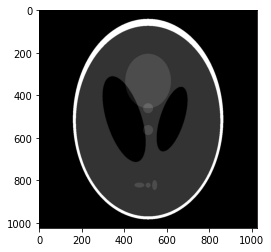

In [97]:
S.show_dicom_img()

In [98]:

new_Sin=S.make_dicom_from_sinogram()


180
180
180
180


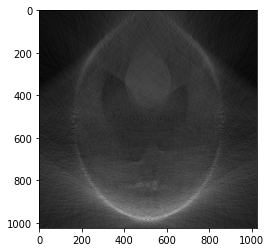

In [99]:
plt.imshow(S.new_photo, cmap='gray')